In [1]:
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import copy
import numpy as np
from torchvision import datasets, transforms
import torch

from utils.sampling import mnist_iid, mnist_noniid, cifar_iid, cifar_noniid
from utils.options import args_parser
from models.Update import LocalUpdate
from models.Nets import MLP, CNNMnist, CNNCifar, LeNet, CNNMnist2
from models.Fed import FedAvg
from models.Fed import FedQAvg, Quantization, Quantization_Finite, my_score, my_score_Finite
from models.test import test_img


import math


# from sympy import * 
from utils.functions import *

%load_ext autoreload
%autoreload 2

In [2]:
class my_argument:    
    epochs = 200    #"rounds of training"
    num_users = 40  # "number of users: K"
    frac = 0.5 #"the fraction of clients: C"
    local_ep=1 #"the number of local epochs: E"
    local_bs=100 #"local batch size: B"
    bs=100 #"test batch size"
    lr=0.03 #"learning rate"
    momentum=0.5 # "SGD momentum (default: 0.5)"
    split='user' # "train-test split type, user or sample"
    weight_decay = 5e-4
    opt = 'SGD' #'ADAM'
    loss = 'Cross'

    # model arguments
    model = 'cnn'
    kernel_num=9 #, help='number of each kind of kernel')
    kernel_sizes='3,4,5' #  help='comma-separated kernel size to use for convolution')
    norm='batch_norm' #, help="batch_norm, layer_norm, or None")
    num_filters=32 #, help="number of filters for conv nets")
    max_pool='True' #help="Whether use max pooling rather than strided convolutions")

    # other arguments
    dataset='mnist' #, help="name of dataset")
    iid=0
    num_classes=10#, help="number of classes")
    num_channels=1#, help="number of channels of imges")
    gpu=1#, help="GPU ID, -1 for CPU")
    stopping_rounds=10#, help='rounds of early stopping')
    verbose='False'#, help='verbose print')
    seed=1#, help='random seed (default: 1)')
    
args = my_argument()

args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')

use_cuda = torch.cuda.is_available()
print(use_cuda)
args.device = torch.device("cuda" if use_cuda else "cpu")
print(args.device)

True
cuda


In [3]:
# load dataset and split users

from torchvision import datasets, transforms

trans_mnist = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
dataset_train = datasets.MNIST('./data/mnist/', train=True, download=True, transform=trans_mnist)
dataset_test = datasets.MNIST('./data/mnist/', train=False, download=True, transform=trans_mnist)
    # sample users

dict_users = mnist_noniid(dataset_train, args.num_users)

img_size = dataset_train[0][0].shape

c:\programdata\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [6]:
print(dict_users[0][0])

print(dataset_train.train_labels[dict_users[0][0]],dataset_train.train_labels[dict_users[0][797]],dataset_train.train_labels[dict_users[0][1499]])

40700
tensor(7) tensor(8) tensor(8)


In [7]:
from models.Nets import *
from utils.functions import *

net_glob = CNNMnist3(args)
net_glob = net_glob.cuda()

net_glob.train()
# copy weights
w_glob = net_glob.state_dict()

d = tensor_dim(w_glob)

print(d)

62346


In [25]:
from models.Nets import *
import pickle

p = 0
N = 40
K = 8

N_trials = 1
Max_iter = 500

lr_array = [0.03]

acc_test_arr  = np.zeros((len(lr_array), N_trials, Max_iter))
loss_test_arr = np.zeros((len(lr_array), N_trials, Max_iter))



P_random = []


for trial_idx in range(N_trials):
    

    for lr_idx in range(len(lr_array)):
        
        args.lr = lr_array[lr_idx]
        
        print()
        print('Learning Rate =',args.lr)
        print()
        net_glob = CNNMnist2(args)
        net_glob = net_glob.cuda()
        print(net_glob)

        net_glob.train()

        # copy weights
        w_glob = net_glob.state_dict()
        
#         w_glob_array = []
#         w_locals_array = []
        
        w_locals_array_np = np.zeros((Max_iter,N,d))
        w_glob_array_np = np.zeros((Max_iter,d))
        
        for iter in range(Max_iter): #args.epochs
            
#             if iter >= 200:
#                 args.lr = lr_array[lr_idx] * 0.1
#             elif iter >= 300:
#                 args.lr = lr_array[lr_idx] * 0.01
            
            w_locals, loss_locals = [], []
            w_locals_all = []
            
# #             u = np.random.binomial(1, 1-p, size=(N))
#             u = np.ones((N,))
#             for u_idx in range(N):
#                 p_sel = p_per_user[u_idx]
#                 u[u_idx] = np.random.binomial(1, 1-p_sel, size=1)[0]
            
#             result = np.where(u == 1)

            ###############################
            # 1. Random Selection
            ###############################
            idxs_users = np.random.choice(N, K, replace=False)

            p_tmp = np.zeros(N)
            p_tmp[idxs_users] = 1

            P_random.append(p_tmp)

#             print('Learning Rate =',args.lr)
        #     idxs_users = np.random.choice(range(N), K, replace=False)
            for idx in range(N):
        #         print(idx)
                local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[idx])
                w, loss = local.train(net=copy.deepcopy(net_glob).to(args.device))
                
                w_locals_all.append(copy.deepcopy(w))
                loss_locals.append(copy.deepcopy(loss))
                
                if idx in idxs_users:
                    w_locals.append(copy.deepcopy(w))
                    
                stt_pos = 0
                for k in w.keys():
                    tmp1 = w[k].cpu().detach().numpy()
                    cur_shape = tmp1.shape
                    _d = np.prod(cur_shape)

                    end_pos = stt_pos + _d

#                     w_glob_array_np[iter,stt_pos:end_pos] = np.reshape(tmp1,(_d,))        

                        
                    w_locals_array_np[iter,idx,stt_pos:end_pos] = np.reshape(tmp1,(_d,))

                    stt_pos = end_pos
            
            
                
                
            # update global weights
            w_glob = FedAvg(w_locals)
            
            
            stt_pos = 0
            for k in w_glob.keys():
                tmp2 = w_glob[k].cpu().detach().numpy()
                cur_shape = tmp2.shape
                _d = np.prod(cur_shape)

                end_pos = stt_pos + _d
                
#                 print(_d, stt_pose, end_pos)

                w_glob_array_np[iter,stt_pos:end_pos] = np.reshape(tmp2,(_d,))

                stt_pos = end_pos
            
            
#             w_locals_array.append(w_locals_all)
            w_glob_array.append(w_glob)
            
            ModelDiff_tensor(net_glob.state_dict(), w_glob_array[iter])     
            
            # copy weight to net_glob
            if iter < 500:
                print('net_glob is updated !!')
                net_glob.load_state_dict(w_glob)
#             else:
#                 net_glob.load_state_dict(w_glob_prev)

            # print loss
            loss_avg = sum(loss_locals) / len(loss_locals)

    #         loss_train.append(loss_avg)

            acc_test, loss_test = test_img(net_glob, dataset_test, args)
            acc_test_arr[lr_idx][trial_idx][iter]  = acc_test
            loss_test_arr[lr_idx][trial_idx][iter] = loss_test
            if iter % 1 ==0:
                print('Round {:3d}, Train average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_avg,acc_test))
            #print(loss_train)
            
            if iter % 100 == 99:
                PATH = "./save_models/MNIST_NonIID_CNN_N40_K8_net_glob_iter"+str(iter)
                torch.save(net_glob.state_dict(), PATH)
            
# filehandler = open("./save_models/MNIST_CNN_N40_K8_w_locals_array_Maxiter"+str(Max_iter),"wb")
# pickle.dump(w_locals_array, filehandler)

# filehandler = open("./save_models/MNIST_CNN_N40_K8_w_glob_array_Maxiter"+str(Max_iter),"wb")
# pickle.dump(w_glob_array, filehandler)
            


Learning Rate = 0.03

CNNMnist2(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=10, bias=True)
)
[[36.20980613]] [[35.66808174]] [[73.155904]]
net_glob is updated !!

Test set: Average loss: 3.1105 
Accuracy: 958/10000 (9.58%)

Round   0, Train average loss 0.471 Test accuracy 9.580
[[36.31609106]] [[35.71383303]] [[73.38286083]]
net_glob is updated !!

Test set: Average loss: 2.3948 
Accuracy: 1707/10000 (17.07%)

Round   1, Train average loss 0.731 Test accuracy 17.070
[[36.45059104]] [[35.57830136]] [[72.93069868]]
net_glob is updated !!

Test set: Average loss: 2.3381 
Accuracy: 1809/10000 (18.09%)

Round   2, Train average loss 1.008 Test accuracy 18.090
[[36.45453752]] [[35.63510922]] [[73.01970622]]
net_glob is updated !!

Test set: Average loss: 2.2930 
Accuracy: 1654/10000 (16.54%)

Round   3, Train average loss 1.526 Test accuracy 16.540
[[36.32020343]] [[

[[41.26288557]] [[44.25636817]] [[85.15895193]]
net_glob is updated !!

Test set: Average loss: 0.6134 
Accuracy: 8070/10000 (80.70%)

Round  42, Train average loss 0.270 Test accuracy 80.700
[[41.36455894]] [[44.31604496]] [[85.33890804]]
net_glob is updated !!

Test set: Average loss: 0.6461 
Accuracy: 7934/10000 (79.34%)

Round  43, Train average loss 0.269 Test accuracy 79.340
[[41.3440692]] [[44.37808482]] [[85.40466334]]
net_glob is updated !!

Test set: Average loss: 0.7246 
Accuracy: 7336/10000 (73.36%)

Round  44, Train average loss 0.272 Test accuracy 73.360
[[41.466522]] [[44.44315094]] [[85.59609062]]
net_glob is updated !!

Test set: Average loss: 0.6006 
Accuracy: 8031/10000 (80.31%)

Round  45, Train average loss 0.277 Test accuracy 80.310
[[41.44857792]] [[44.55532386]] [[85.68293843]]
net_glob is updated !!

Test set: Average loss: 0.6567 
Accuracy: 7769/10000 (77.69%)

Round  46, Train average loss 0.268 Test accuracy 77.690
[[41.48753627]] [[44.65549208]] [[85.838804

[[43.31620631]] [[46.80976324]] [[89.86279075]]
net_glob is updated !!

Test set: Average loss: 0.4185 
Accuracy: 8554/10000 (85.54%)

Round  85, Train average loss 0.254 Test accuracy 85.540
[[43.3371378]] [[46.88053749]] [[89.94833898]]
net_glob is updated !!

Test set: Average loss: 0.4350 
Accuracy: 8451/10000 (84.51%)

Round  86, Train average loss 0.250 Test accuracy 84.510
[[43.39366675]] [[46.91969594]] [[90.0597274]]
net_glob is updated !!

Test set: Average loss: 0.4238 
Accuracy: 8520/10000 (85.20%)

Round  87, Train average loss 0.252 Test accuracy 85.200
[[43.45841486]] [[46.98132163]] [[90.1967039]]
net_glob is updated !!

Test set: Average loss: 0.4781 
Accuracy: 8355/10000 (83.55%)

Round  88, Train average loss 0.250 Test accuracy 83.550
[[43.46495648]] [[47.0436987]] [[90.27608984]]
net_glob is updated !!

Test set: Average loss: 0.3897 
Accuracy: 8614/10000 (86.14%)

Round  89, Train average loss 0.254 Test accuracy 86.140
[[43.48129398]] [[47.08594278]] [[90.3712747

[[44.58112968]] [[48.38100436]] [[92.72326283]]
net_glob is updated !!

Test set: Average loss: 0.3457 
Accuracy: 8724/10000 (87.24%)

Round 128, Train average loss 0.247 Test accuracy 87.240
[[44.66334771]] [[48.40519351]] [[92.84310222]]
net_glob is updated !!

Test set: Average loss: 0.3792 
Accuracy: 8604/10000 (86.04%)

Round 129, Train average loss 0.245 Test accuracy 86.040
[[44.69380019]] [[48.43414909]] [[92.93656189]]
net_glob is updated !!

Test set: Average loss: 0.3669 
Accuracy: 8647/10000 (86.47%)

Round 130, Train average loss 0.246 Test accuracy 86.470
[[44.72074382]] [[48.46112052]] [[92.98255616]]
net_glob is updated !!

Test set: Average loss: 0.3751 
Accuracy: 8634/10000 (86.34%)

Round 131, Train average loss 0.245 Test accuracy 86.340
[[44.66728563]] [[48.48087997]] [[92.95804107]]
net_glob is updated !!

Test set: Average loss: 0.3679 
Accuracy: 8620/10000 (86.20%)

Round 132, Train average loss 0.246 Test accuracy 86.200
[[44.69760666]] [[48.51144692]] [[93.022

[[44.95304526]] [[49.29145801]] [[94.18311783]]
net_glob is updated !!

Test set: Average loss: 0.3442 
Accuracy: 8710/10000 (87.10%)

Round 171, Train average loss 0.242 Test accuracy 87.100
[[44.93933595]] [[49.33234887]] [[94.1904807]]
net_glob is updated !!

Test set: Average loss: 0.3506 
Accuracy: 8658/10000 (86.58%)

Round 172, Train average loss 0.242 Test accuracy 86.580
[[44.95766324]] [[49.34881152]] [[94.22202215]]
net_glob is updated !!

Test set: Average loss: 0.3412 
Accuracy: 8716/10000 (87.16%)

Round 173, Train average loss 0.241 Test accuracy 87.160
[[44.97107985]] [[49.39583503]] [[94.28249038]]
net_glob is updated !!

Test set: Average loss: 0.3700 
Accuracy: 8588/10000 (85.88%)

Round 174, Train average loss 0.241 Test accuracy 85.880
[[44.99003883]] [[49.42358387]] [[94.3470647]]
net_glob is updated !!

Test set: Average loss: 0.3531 
Accuracy: 8653/10000 (86.53%)

Round 175, Train average loss 0.242 Test accuracy 86.530
[[45.00085802]] [[49.44484007]] [[94.37606

[[45.17070192]] [[36.91485808]] [[9.82400144]]
net_glob is updated !!

Test set: Average loss: 0.3228 
Accuracy: 8767/10000 (87.67%)

Round 214, Train average loss 0.240 Test accuracy 87.670
[[45.15254765]] [[37.02356704]] [[9.46445558]]
net_glob is updated !!

Test set: Average loss: 0.3155 
Accuracy: 8814/10000 (88.14%)

Round 215, Train average loss 0.239 Test accuracy 88.140
[[45.15232725]] [[37.29163029]] [[9.20387689]]
net_glob is updated !!

Test set: Average loss: 0.3297 
Accuracy: 8729/10000 (87.29%)

Round 216, Train average loss 0.239 Test accuracy 87.290
[[45.15171735]] [[37.41798005]] [[9.03137222]]
net_glob is updated !!

Test set: Average loss: 0.3199 
Accuracy: 8789/10000 (87.89%)

Round 217, Train average loss 0.240 Test accuracy 87.890
[[45.1567826]] [[37.55903523]] [[9.05523406]]
net_glob is updated !!

Test set: Average loss: 0.3188 
Accuracy: 8772/10000 (87.72%)

Round 218, Train average loss 0.239 Test accuracy 87.720
[[45.15567768]] [[37.56794331]] [[8.68304562]]

[[45.09354044]] [[42.1099382]] [[3.75950367]]
net_glob is updated !!

Test set: Average loss: 0.3220 
Accuracy: 8752/10000 (87.52%)

Round 257, Train average loss 0.238 Test accuracy 87.520
[[45.05362415]] [[42.30789711]] [[3.63607918]]
net_glob is updated !!

Test set: Average loss: 0.3596 
Accuracy: 8618/10000 (86.18%)

Round 258, Train average loss 0.238 Test accuracy 86.180
[[45.04399285]] [[42.3604014]] [[3.57779268]]
net_glob is updated !!

Test set: Average loss: 0.3123 
Accuracy: 8785/10000 (87.85%)

Round 259, Train average loss 0.241 Test accuracy 87.850
[[45.05570744]] [[42.40122453]] [[3.50850748]]
net_glob is updated !!

Test set: Average loss: 0.3222 
Accuracy: 8775/10000 (87.75%)

Round 260, Train average loss 0.238 Test accuracy 87.750
[[45.06253548]] [[42.49117665]] [[3.44618751]]
net_glob is updated !!

Test set: Average loss: 0.3042 
Accuracy: 8835/10000 (88.35%)

Round 261, Train average loss 0.238 Test accuracy 88.350
[[45.0488187]] [[42.50599587]] [[3.39904769]]
n

[[45.17436554]] [[43.87121063]] [[2.36344118]]
net_glob is updated !!

Test set: Average loss: 0.3109 
Accuracy: 8819/10000 (88.19%)

Round 300, Train average loss 0.241 Test accuracy 88.190
[[45.18588197]] [[43.90968938]] [[2.31872318]]
net_glob is updated !!

Test set: Average loss: 0.3049 
Accuracy: 8840/10000 (88.40%)

Round 301, Train average loss 0.239 Test accuracy 88.400
[[45.20619188]] [[43.84313628]] [[2.25703014]]
net_glob is updated !!

Test set: Average loss: 0.3140 
Accuracy: 8797/10000 (87.97%)

Round 302, Train average loss 0.239 Test accuracy 87.970
[[45.22958113]] [[43.91430012]] [[2.2154594]]
net_glob is updated !!

Test set: Average loss: 0.3076 
Accuracy: 8811/10000 (88.11%)

Round 303, Train average loss 0.239 Test accuracy 88.110
[[45.2521202]] [[43.98403727]] [[2.18926909]]
net_glob is updated !!

Test set: Average loss: 0.3171 
Accuracy: 8772/10000 (87.72%)

Round 304, Train average loss 0.239 Test accuracy 87.720
[[45.25419019]] [[44.06883841]] [[2.16147526]]


[[45.12842103]] [[44.75020806]] [[1.58057362]]
net_glob is updated !!

Test set: Average loss: 0.3064 
Accuracy: 8827/10000 (88.27%)

Round 343, Train average loss 0.235 Test accuracy 88.270
[[45.13527632]] [[44.75230418]] [[1.56656656]]
net_glob is updated !!

Test set: Average loss: 0.3034 
Accuracy: 8825/10000 (88.25%)

Round 344, Train average loss 0.236 Test accuracy 88.250
[[45.10524589]] [[44.75875054]] [[1.55128281]]
net_glob is updated !!

Test set: Average loss: 0.3023 
Accuracy: 8804/10000 (88.04%)

Round 345, Train average loss 0.236 Test accuracy 88.040
[[45.11139459]] [[44.77101895]] [[1.53887117]]
net_glob is updated !!

Test set: Average loss: 0.3024 
Accuracy: 8811/10000 (88.11%)

Round 346, Train average loss 0.236 Test accuracy 88.110
[[45.12963423]] [[44.79672529]] [[1.52984736]]
net_glob is updated !!

Test set: Average loss: 0.2985 
Accuracy: 8830/10000 (88.30%)

Round 347, Train average loss 0.235 Test accuracy 88.300
[[45.12401864]] [[44.77185421]] [[1.52539592]

[[45.60579954]] [[44.95892167]] [[1.40335667]]
net_glob is updated !!

Test set: Average loss: 0.3072 
Accuracy: 8799/10000 (87.99%)

Round 386, Train average loss 0.237 Test accuracy 87.990
[[45.594205]] [[44.99488591]] [[1.37796949]]
net_glob is updated !!

Test set: Average loss: 0.2907 
Accuracy: 8849/10000 (88.49%)

Round 387, Train average loss 0.237 Test accuracy 88.490
[[45.58929748]] [[44.9972735]] [[1.38095354]]
net_glob is updated !!

Test set: Average loss: 0.2983 
Accuracy: 8811/10000 (88.11%)

Round 388, Train average loss 0.236 Test accuracy 88.110
[[45.5825227]] [[44.98718493]] [[1.37412794]]
net_glob is updated !!

Test set: Average loss: 0.3062 
Accuracy: 8788/10000 (87.88%)

Round 389, Train average loss 0.236 Test accuracy 87.880
[[45.56467587]] [[44.98295631]] [[1.36296676]]
net_glob is updated !!

Test set: Average loss: 0.2873 
Accuracy: 8861/10000 (88.61%)

Round 390, Train average loss 0.237 Test accuracy 88.610
[[45.57767313]] [[44.97462564]] [[1.36786847]]
ne

[[45.30205099]] [[45.26107422]] [[1.13998855]]
net_glob is updated !!

Test set: Average loss: 0.2988 
Accuracy: 8826/10000 (88.26%)

Round 429, Train average loss 0.234 Test accuracy 88.260
[[45.26351558]] [[45.23313507]] [[1.12099201]]
net_glob is updated !!

Test set: Average loss: 0.3097 
Accuracy: 8777/10000 (87.77%)

Round 430, Train average loss 0.235 Test accuracy 87.770
[[45.27672025]] [[45.21509054]] [[1.11960784]]
net_glob is updated !!

Test set: Average loss: 0.2878 
Accuracy: 8860/10000 (88.60%)

Round 431, Train average loss 0.236 Test accuracy 88.600
[[45.28081717]] [[45.22719988]] [[1.11131291]]
net_glob is updated !!

Test set: Average loss: 0.2830 
Accuracy: 8862/10000 (88.62%)

Round 432, Train average loss 0.235 Test accuracy 88.620
[[45.29518946]] [[45.21952426]] [[1.0975378]]
net_glob is updated !!

Test set: Average loss: 0.2809 
Accuracy: 8877/10000 (88.77%)

Round 433, Train average loss 0.234 Test accuracy 88.770
[[45.29344047]] [[45.19929062]] [[1.09572691]]

[[44.91619689]] [[45.03936615]] [[0.9570758]]
net_glob is updated !!

Test set: Average loss: 0.3424 
Accuracy: 8665/10000 (86.65%)

Round 472, Train average loss 0.234 Test accuracy 86.650
[[44.88476801]] [[45.05026106]] [[0.96076998]]
net_glob is updated !!

Test set: Average loss: 0.3041 
Accuracy: 8786/10000 (87.86%)

Round 473, Train average loss 0.236 Test accuracy 87.860
[[44.8747458]] [[45.04394201]] [[0.94334118]]
net_glob is updated !!

Test set: Average loss: 0.2909 
Accuracy: 8827/10000 (88.27%)

Round 474, Train average loss 0.234 Test accuracy 88.270
[[44.87735253]] [[45.05630484]] [[0.94012943]]
net_glob is updated !!

Test set: Average loss: 0.2822 
Accuracy: 8868/10000 (88.68%)

Round 475, Train average loss 0.233 Test accuracy 88.680
[[44.87026608]] [[45.05008241]] [[0.93940494]]
net_glob is updated !!

Test set: Average loss: 0.2842 
Accuracy: 8858/10000 (88.58%)

Round 476, Train average loss 0.233 Test accuracy 88.580
[[44.85437883]] [[45.03690192]] [[0.93387942]]


In [27]:
P_random = np.array(P_random)

print(np.shape(P_random))

(500, 40)


In [28]:
# Pseudo Inversion
P_random_tmp = P_random[260:300,:]

PT = P_random_tmp.transpose()

print(np.shape(PT))

PTP = np.matmul(P_random_tmp.transpose(), P_random_tmp)

print(np.linalg.matrix_rank(PTP))

PTP_inv=np.linalg.pinv(PTP)


# print(np.shape(PT), np.shape(w_glob_array_np[10:60,:]))
Pw_glob = np.matmul(PT, w_glob_array_np[260:300,:])
w_recon_np = K * np.matmul(PTP_inv, Pw_glob)

# ModelDiff_np(w_locals_array_np[-1,1,:], w_recon_np[1])
l2_diff = np.zeros((N))
for i in range(N-1):
    l2_diff[i] = ModelDiff_np(w_locals_array_np[260,i,:], (w_recon_np[i]+w_recon_np[i+1])/2)
print()
print()
l2_diff_ = np.zeros((N))
for i in range(N):
    l2_diff_[i] = ModelDiff_np(w_locals_array_np[260,i,:], w_recon_np[i])

print(np.sum(l2_diff)/N, np.sum(l2_diff_)/N)
# w_recon_np = K * np.matmul(pinv, w_glob_array_np[10:50,:])
# u, s, vh = np.linalg.svd(PTP, full_matrices=True)

# print(s)

(40, 40)
40
[[45.11347587]] [[57.56493237]] [[9.88459414]]
[[45.06166125]] [[46.08330693]] [[1.23249458]]
[[45.08332323]] [[89.32356478]] [[48.78044242]]
[[45.10018486]] [[97.05632773]] [[56.46577322]]
[[45.13946952]] [[83.39793165]] [[39.19530792]]
[[45.1682111]] [[53.54351855]] [[8.98731686]]
[[45.06014484]] [[123.5963247]] [[77.08259569]]
[[44.98212697]] [[101.50533234]] [[57.13177715]]
[[44.95527049]] [[83.03442767]] [[38.44616281]]
[[45.09457055]] [[56.80745852]] [[10.12496583]]
[[45.07276209]] [[112.91740201]] [[66.1472108]]
[[45.08603459]] [[52.29430586]] [[7.15653113]]
[[45.08523449]] [[116.8727432]] [[72.0502964]]
[[45.05599313]] [[95.9279887]] [[51.05106646]]
[[45.07246777]] [[127.86338462]] [[81.07367719]]
[[44.97584087]] [[221.34518598]] [[175.54092925]]
[[45.07988807]] [[74.79157128]] [[30.33736644]]
[[45.08386066]] [[73.23700307]] [[26.79661748]]
[[45.07860319]] [[115.61449094]] [[70.5827577]]
[[45.24767515]] [[441.59741567]] [[393.38272998]]
[[45.15482003]] [[108.8557017

In [9]:
net_glob = CNNMnist2(args)
net_glob = net_glob.cuda()

PATH = "./save_models/MNIST_NonIID_CNN_N40_K8_net_glob_iter"+str(199)
net_glob.load_state_dict(torch.load(PATH))
net_glob.eval()

acc_test, loss_test = test_img(net_glob, dataset_test, args)


Test set: Average loss: 0.3243 
Accuracy: 8773/10000 (87.73%)



In [10]:


p = 0
N = 40
K = 8

args.local_ep=1

N_trials = 1
Max_iter = 100

lr_array = [0.03]

acc_test_arr_v2  = np.zeros((len(lr_array), N_trials, Max_iter))
loss_test_arr_v2 = np.zeros((len(lr_array), N_trials, Max_iter))



P_random = []


for trial_idx in range(N_trials):
    

    for lr_idx in range(len(lr_array)):
        
        print()
        print('Learning Rate =',args.lr)
        print()
#         net_glob = CNNMnist2(args)
#         net_glob = net_glob.cuda()
#         print(net_glob)

        net_glob.train()

        # copy weights
        w_glob = net_glob.state_dict()
        
#         w_glob_array = []
#         w_locals_array = []
        
        w_locals_array_np_v2 = np.zeros((Max_iter,N,d))
        w_glob_array_np_v2 = np.zeros((Max_iter,d))
        
        w_glob_array = []
        
        for iter in range(Max_iter): #args.epochs
            
            args.lr = lr_array[lr_idx]/(200)
#             if iter >= 200:
#                 args.lr = lr_array[lr_idx] * 0.1
#             elif iter >= 300:
#                 args.lr = lr_array[lr_idx] * 0.01
            
            w_locals, loss_locals = [], []
            w_locals_all = []
            
# #             u = np.random.binomial(1, 1-p, size=(N))
#             u = np.ones((N,))
#             for u_idx in range(N):
#                 p_sel = p_per_user[u_idx]
#                 u[u_idx] = np.random.binomial(1, 1-p_sel, size=1)[0]
            
#             result = np.where(u == 1)

            ###############################
            # 1. Random Selection
            ###############################
            idxs_users = np.random.choice(N, K, replace=False)

            p_tmp = np.zeros(N)
            p_tmp[idxs_users] = 1

            P_random.append(p_tmp)

#             print('Learning Rate =',args.lr)
        #     idxs_users = np.random.choice(range(N), K, replace=False)
            for idx in range(N):
        #         print(idx)
                local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[idx])
                w, loss = local.train(net=copy.deepcopy(net_glob).to(args.device))
                
                w_locals_all.append(copy.deepcopy(w))
                loss_locals.append(copy.deepcopy(loss))
                
                if idx in idxs_users:
                    w_locals.append(copy.deepcopy(w))
                    
                stt_pos = 0
                for k in w.keys():
                    tmp1 = w[k].cpu().detach().numpy()
                    cur_shape = tmp1.shape
                    _d = np.prod(cur_shape)

                    end_pos = stt_pos + _d

#                     w_glob_array_np[iter,stt_pos:end_pos] = np.reshape(tmp1,(_d,))        

                        
                    w_locals_array_np_v2[iter,idx,stt_pos:end_pos] = np.reshape(tmp1,(_d,))

                    stt_pos = end_pos
            
            
                
                
            # update global weights
            w_glob = FedAvg(w_locals)
            
            
            stt_pos = 0
            for k in w_glob.keys():
                tmp2 = w_glob[k].cpu().detach().numpy()
                cur_shape = tmp2.shape
                _d = np.prod(cur_shape)

                end_pos = stt_pos + _d
                
#                 print(_d, stt_pose, end_pos)

                w_glob_array_np_v2[iter,stt_pos:end_pos] = np.reshape(tmp2,(_d,))

                stt_pos = end_pos
            
            
#             w_locals_array.append(w_locals_all)
            w_glob_array.append(w_glob)
            
            ModelDiff_tensor(net_glob.state_dict(), w_glob_array[iter])     
            
            # copy weight to net_glob
            if iter < 1000:
                print('net_glob is updated !!')
                net_glob.load_state_dict(w_glob)
#             else:
#                 net_glob.load_state_dict(w_glob_prev)

            # print loss
            loss_avg = sum(loss_locals) / len(loss_locals)

    #         loss_train.append(loss_avg)

            acc_test, loss_test = test_img(net_glob, dataset_test, args)
            acc_test_arr_v2[lr_idx][trial_idx][iter]  = acc_test
            loss_test_arr_v2[lr_idx][trial_idx][iter] = loss_test
            if iter % 1 ==0:
                print('Round {:3d}, Train average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_avg,acc_test))
            #print(loss_train)
            
            if iter % 100 == 99:
                PATH = "./save_models/MNIST_NonIID_CNN_N40_K8_net_glob_iter"+str(1400+iter)
                torch.save(net_glob.state_dict(), PATH)


Learning Rate = 0.00015

[[45.09035491]] [[45.09102049]] [[2.23243627e-06]]
net_glob is updated !!

Test set: Average loss: 0.3239 
Accuracy: 8773/10000 (87.73%)

Round   0, Train average loss 0.334 Test accuracy 87.730
[[45.09102049]] [[45.09211844]] [[4.51292293e-06]]
net_glob is updated !!

Test set: Average loss: 0.3229 
Accuracy: 8778/10000 (87.78%)

Round   1, Train average loss 0.333 Test accuracy 87.780
[[45.09211844]] [[45.09283159]] [[5.27015701e-06]]
net_glob is updated !!

Test set: Average loss: 0.3223 
Accuracy: 8783/10000 (87.83%)

Round   2, Train average loss 0.333 Test accuracy 87.830
[[45.09283159]] [[45.0939073]] [[2.80789472e-06]]
net_glob is updated !!

Test set: Average loss: 0.3218 
Accuracy: 8784/10000 (87.84%)

Round   3, Train average loss 0.332 Test accuracy 87.840
[[45.0939073]] [[45.09424912]] [[2.54625493e-06]]
net_glob is updated !!

Test set: Average loss: 0.3214 
Accuracy: 8786/10000 (87.86%)

Round   4, Train average loss 0.331 Test accuracy 87.860
[

[[45.11737507]] [[45.11770979]] [[9.99811104e-07]]
net_glob is updated !!

Test set: Average loss: 0.3118 
Accuracy: 8794/10000 (87.94%)

Round  42, Train average loss 0.323 Test accuracy 87.940
[[45.11770979]] [[45.11830076]] [[1.08330752e-06]]
net_glob is updated !!

Test set: Average loss: 0.3118 
Accuracy: 8794/10000 (87.94%)

Round  43, Train average loss 0.323 Test accuracy 87.940
[[45.11830076]] [[45.11881485]] [[1.31003366e-06]]
net_glob is updated !!

Test set: Average loss: 0.3117 
Accuracy: 8791/10000 (87.91%)

Round  44, Train average loss 0.323 Test accuracy 87.910
[[45.11881485]] [[45.11976075]] [[2.86754093e-06]]
net_glob is updated !!

Test set: Average loss: 0.3116 
Accuracy: 8797/10000 (87.97%)

Round  45, Train average loss 0.323 Test accuracy 87.970
[[45.11976075]] [[45.12032562]] [[1.59974322e-06]]
net_glob is updated !!

Test set: Average loss: 0.3114 
Accuracy: 8799/10000 (87.99%)

Round  46, Train average loss 0.323 Test accuracy 87.990
[[45.12032562]] [[45.1208


Test set: Average loss: 0.3088 
Accuracy: 8807/10000 (88.07%)

Round  84, Train average loss 0.320 Test accuracy 88.070
[[45.14209606]] [[45.14289966]] [[3.39621282e-06]]
net_glob is updated !!

Test set: Average loss: 0.3087 
Accuracy: 8809/10000 (88.09%)

Round  85, Train average loss 0.320 Test accuracy 88.090
[[45.14289966]] [[45.14359761]] [[2.50126528e-06]]
net_glob is updated !!

Test set: Average loss: 0.3086 
Accuracy: 8810/10000 (88.10%)

Round  86, Train average loss 0.320 Test accuracy 88.100
[[45.14359761]] [[45.14442507]] [[1.47331059e-06]]
net_glob is updated !!

Test set: Average loss: 0.3086 
Accuracy: 8808/10000 (88.08%)

Round  87, Train average loss 0.320 Test accuracy 88.080
[[45.14442507]] [[45.14499996]] [[1.32232087e-06]]
net_glob is updated !!

Test set: Average loss: 0.3085 
Accuracy: 8810/10000 (88.10%)

Round  88, Train average loss 0.320 Test accuracy 88.100
[[45.14499996]] [[45.14562984]] [[2.54396649e-06]]
net_glob is updated !!

Test set: Average loss: 

In [9]:
import pickle

pickle.dump(acc_test_arr_v2[:,:,0:100],  open('./results/MNIST_nonIID_CNN2_accuracy_Random_N40_K20_iter1400_1500', 'wb'), -1)
pickle.dump(loss_test_arr_v2[:,:,0:100], open('./results/MNIST_nonIID_CNN2_loss_Random_N40_K20_iter1400_1500', 'wb'), -1)

# pickle.dump(acc_test_arr,  open('./results/MNIST_nonIID_CNN2_accuracy_Random_N40_K20_iter1000_1200', 'wb'), -1)
# pickle.dump(loss_test_arr, open('./results/MNIST_nonIID_CNN2_loss_Random_N40_K20_iter1000_1200', 'wb'), -1)

# acc_test_arr_pre = pickle.load(open('./results/MNIST_nonIID_CNN2_accuracy_Random_N40_K20_iter500_1000','rb'))
# loss_test_arr_pre = pickle.load(open('./results/MNIST_nonIID_CNN2_loss_Random_N40_K20_iter500_1000','rb'))

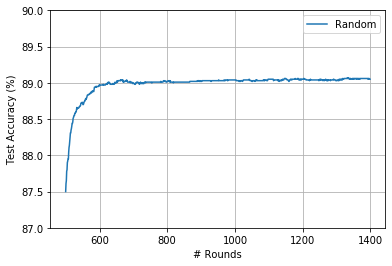

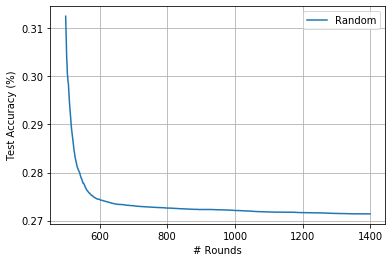

In [104]:


plt.plot(range(500,1400),np.concatenate([acc_test_arr_pre[0,0,:], acc_test_arr[0,0,:], acc_test_arr_v2[0,0,0:200]]), label='Random')
plt.ylabel('Test Accuracy (%)')
plt.xlabel('# Rounds')
plt.ylim([87,90])
plt.grid()
plt.legend()
plt.show()

plt.plot(range(500,1400),np.concatenate([loss_test_arr_pre[0,0,:], loss_test_arr[0,0,:], loss_test_arr_v2[0,0,0:200]]), label='Random')
plt.ylabel('Test Accuracy (%)')
plt.xlabel('# Rounds')
# plt.ylim([-0.1,1.1])
plt.grid()
plt.legend()
plt.show()

In [12]:
P_random = np.array(P_random)

print(np.shape(P_random))

print(np.shape(w_glob_array_np_v2))

print(np.sum(P_random, axis=0))

(100, 40)
(100, 62346)
[18. 21. 24. 24. 16. 17. 15. 14. 29. 23. 17. 18. 17. 27. 18. 23. 18. 19.
 15. 17. 14. 23. 19. 18. 20. 14. 13. 28. 24. 20. 22. 19. 20. 22. 24. 26.
 22. 19. 17. 26.]


# gradient computation

In [11]:
print(np.shape(w_locals_array_np_v2))
print(np.shape(w_glob_array_np_v2))

grad_locals_array_np_v2 = np.zeros((100,N,d))
grad_glob_array_np_v2 = np.zeros((100,d))

for i in range(1, 99):
#     print(i)
    grad_locals_array_np_v2[i+1,:,:] = (w_locals_array_np_v2[i,:,:] - w_glob_array_np_v2[i-1,:])*1400
    
    grad_glob_array_np_v2[i-1,:] = (w_glob_array_np_v2[i,:] - w_glob_array_np_v2[i-1,:])*1400
    
    ModelDiff_np(grad_locals_array_np_v2[i+1,0,:], grad_glob_array_np_v2[i-1,:])
    

(100, 40, 62346)
(100, 62346)
[[158.21327955]] [[8.84532894]] [[125.04237207]]
[[152.73572428]] [[10.32950774]] [[122.62436029]]
[[147.18497771]] [[5.50347366]] [[124.88875901]]
[[143.75347072]] [[4.99065967]] [[151.09850582]]
[[144.23926235]] [[5.52623002]] [[112.9298726]]
[[139.76156453]] [[5.86010963]] [[110.75194247]]
[[135.98044878]] [[3.89170519]] [[113.62725985]]
[[132.71884648]] [[6.09421754]] [[144.50502968]]
[[133.06830679]] [[10.81839507]] [[75.07469926]]
[[125.18717646]] [[5.19518629]] [[138.93251425]]
[[126.06769917]] [[8.18372565]] [[105.0356753]]
[[123.95471678]] [[8.98922272]] [[73.75847096]]
[[117.54043027]] [[4.29658532]] [[86.74879009]]
[[113.70068296]] [[2.37751417]] [[124.14950975]]
[[114.57550862]] [[3.49933509]] [[105.35682452]]
[[113.04294803]] [[8.61987789]] [[65.86582616]]
[[107.08095435]] [[3.70035365]] [[91.62306128]]
[[105.0262822]] [[5.77180683]] [[127.64511365]]
[[106.81938455]] [[2.31181584]] [[89.19120747]]
[[104.81520702]] [[3.13327816]] [[118.26548184

In [13]:
iter_idx = 50
p_temp = np.reshape(P_random[iter_idx,:],(1,N))
temp = np.matmul(p_temp, grad_locals_array_np_v2[iter_idx,:,:])/K
ModelDiff_np(temp, grad_glob_array_np_v2[iter_idx-2,:])
ModelDiff_np(temp, grad_glob_array_np_v2[iter_idx-1,:])
ModelDiff_np(temp, grad_glob_array_np_v2[iter_idx-0,:])
ModelDiff_np(temp, grad_glob_array_np_v2[iter_idx+1,:])
ModelDiff_np(temp, grad_glob_array_np_v2[iter_idx+2,:])

print(np.shape(w_locals_array_np_v2[iter_idx,:,:]))

p_temp = np.reshape(P_random[iter_idx,:],(1,N))
temp = np.matmul(p_temp, w_locals_array_np_v2[iter_idx,:,:])/K
temp = np.reshape(temp, (d,))
print(np.shape(temp))
ModelDiff_np(temp, w_glob_array_np_v2[iter_idx,:])

[[1.99293432]] [[1.84099746]] [[3.84945838]]
[[1.99293432]] [[1.99091945]] [[0.0008409]]
[[1.99293432]] [[1.43293223]] [[1.0731225]]
[[1.99293432]] [[3.55989087]] [[5.52470489]]
[[1.99293432]] [[6.19302176]] [[3.52756645]]
(40, 62346)
(62346,)
[[45.1227395]] [[45.12273882]] [[1.24442894e-13]]


array([[2.75787543e-15]])

In [14]:
# Pseudo Inversion

offset = 1
P_random_tmp = P_random[40+offset:90+offset,:]

PT = P_random_tmp.transpose()

print(np.shape(PT))

PTP = np.matmul(P_random_tmp.transpose(), P_random_tmp)

print(np.linalg.matrix_rank(PTP))

PTP_inv=np.linalg.pinv(PTP)


# print(np.shape(PT), np.shape(w_glob_array_np[10:60,:]))
Pw_glob = np.matmul(PT, grad_glob_array_np_v2[40:90,:])
grad_recon_np = K * np.matmul(PTP_inv, Pw_glob)

# ModelDiff_np(w_locals_array_np[-1,1,:], w_recon_np[1])
l2_diff = np.zeros((N))
l2_diff_ = np.zeros((N))
for i in range(N):
    if i == N-1:
        l2_diff_[i] = ModelDiff_np(grad_locals_array_np_v2[40,i,:], (grad_recon_np[i-1]+grad_recon_np[i])/2)
    else:
        l2_diff_[i] = ModelDiff_np(grad_locals_array_np_v2[40,i,:], (grad_recon_np[i]+grad_recon_np[i+1])/2)
print()
print()
for i in range(N):
    l2_diff[i] = ModelDiff_np(grad_locals_array_np_v2[50,i,:], (grad_recon_np[i]))

print(np.sum(l2_diff_)/N)
print(np.sum(l2_diff)/N)

print(np.sum(l2_diff_)/np.sum(l2_diff))

(40, 50)
40
[[94.52434411]] [[21.14882496]] [[27.62118478]]
[[1.74818775]] [[9.55088684]] [[9.90631917]]
[[42.40201533]] [[8.08654093]] [[15.41952096]]
[[2.29343334]] [[7.29101947]] [[6.7620837]]
[[24.41121044]] [[8.49374766]] [[10.70292408]]
[[14.11808357]] [[7.14715751]] [[8.83611095]]
[[23.04815488]] [[13.29924296]] [[13.52342132]]
[[28.25149969]] [[20.78361183]] [[18.3339173]]
[[29.7340302]] [[27.23268092]] [[0.32039256]]
[[28.68402302]] [[24.08181798]] [[0.47729891]]
[[26.3348799]] [[17.14552724]] [[18.79403711]]
[[43.15674263]] [[25.14066789]] [[17.88101291]]
[[27.98552789]] [[14.45998489]] [[16.17353677]]
[[43.26345572]] [[18.53691469]] [[35.59410809]]
[[55.77188165]] [[17.72643273]] [[26.33835704]]
[[40.36724837]] [[13.19265437]] [[24.16085701]]
[[26.80991327]] [[29.09808719]] [[47.19020956]]
[[116.38262607]] [[34.82614284]] [[43.01421491]]
[[40.03526802]] [[25.01628724]] [[25.14141687]]
[[39.93616165]] [[23.44960299]] [[22.18533072]]
[[51.03818722]] [[16.77050451]] [[18.374398

In [15]:
for i in range(N):
    ModelDiff_np(grad_locals_array_np_v2[iter_idx, 2, :], grad_locals_array_np_v2[iter_idx+1, i, :])

[[42.44739784]] [[92.27106889]] [[142.57820874]]
[[42.44739784]] [[2.04458112]] [[47.4900455]]
[[42.44739784]] [[43.24968852]] [[0.00392476]]
[[42.44739784]] [[2.51753329]] [[51.00369599]]
[[42.44739784]] [[26.23746095]] [[74.18581225]]
[[42.44739784]] [[14.77269585]] [[24.30169554]]
[[42.44739784]] [[20.43750994]] [[62.23948372]]
[[42.44739784]] [[26.92286429]] [[66.82356332]]
[[42.44739784]] [[25.98121038]] [[65.00767565]]
[[42.44739784]] [[24.9311607]] [[64.86158369]]
[[42.44739784]] [[22.83117552]] [[62.08315596]]
[[42.44739784]] [[45.0273514]] [[81.48255113]]
[[42.44739784]] [[30.26037415]] [[74.67877605]]
[[42.44739784]] [[41.18476755]] [[82.52481329]]
[[42.44739784]] [[52.2919079]] [[143.72091798]]
[[42.44739784]] [[39.07241247]] [[79.45112782]]
[[42.44739784]] [[29.26440721]] [[76.13237017]]
[[42.44739784]] [[113.58913521]] [[159.84661252]]
[[42.44739784]] [[41.57052241]] [[77.52419858]]
[[42.44739784]] [[42.14560803]] [[0.61085312]]
[[42.44739784]] [[53.55718832]] [[90.5777293

In [125]:
ModelDiff_np(w_locals_array_np[198,0,:], w_locals_array_np[199,0,:])
for i in range(N):
    print(i)
    ModelDiff_np(w_locals_array_np[150,0,:], w_locals_array_np[150,i,:])

[[44.75913169]] [[44.75922529]] [[2.44796543e-08]]
0
[[44.75599209]] [[44.75599209]] [[0.]]
1
[[44.75599209]] [[44.75589091]] [[1.9070126e-06]]
2
[[44.75599209]] [[44.75594659]] [[1.76214213e-06]]
3
[[44.75599209]] [[44.75594681]] [[1.80246748e-06]]
4
[[44.75599209]] [[44.75598224]] [[4.01437614e-06]]
5
[[44.75599209]] [[44.75602842]] [[3.60583474e-07]]
6
[[44.75599209]] [[44.75592872]] [[2.00917795e-06]]
7
[[44.75599209]] [[44.7557381]] [[1.62897341e-06]]
8
[[44.75599209]] [[44.75569893]] [[1.75513431e-06]]
9
[[44.75599209]] [[44.75593927]] [[1.84431731e-06]]
10
[[44.75599209]] [[44.75587031]] [[2.36578366e-06]]
11
[[44.75599209]] [[44.75591446]] [[1.98395105e-06]]
12
[[44.75599209]] [[44.7560544]] [[1.75044374e-06]]
13
[[44.75599209]] [[44.75599681]] [[2.15224022e-06]]
14
[[44.75599209]] [[44.75602501]] [[3.80992038e-06]]
15
[[44.75599209]] [[44.75570522]] [[1.70164751e-06]]
16
[[44.75599209]] [[44.75598649]] [[2.08211805e-06]]
17
[[44.75599209]] [[44.75591161]] [[1.87072862e-06]]
18

In [113]:
# Pseudo Inversion
P_random_tmp = P_random[150:200,:]

PT = P_random_tmp.transpose()

print(np.shape(PT))

PTP = np.matmul(P_random_tmp.transpose(), P_random_tmp)

print(np.linalg.matrix_rank(PTP))

PTP_inv=np.linalg.pinv(PTP)


# print(np.shape(PT), np.shape(w_glob_array_np[10:60,:]))
Pw_glob = np.matmul(PT, w_glob_array_np[150:200,:])
w_recon_np = K * np.matmul(PTP_inv, Pw_glob)

# ModelDiff_np(w_locals_array_np[-1,1,:], w_recon_np[1])
l2_diff = np.zeros((N))
for i in range(N-1):
    l2_diff[i] = ModelDiff_np(w_locals_array_np[150,i,:], (w_recon_np[i]+w_recon_np[i+1])/2)
print()
print()
l2_diff_ = np.zeros((N))
for i in range(N):
    l2_diff_[i] = ModelDiff_np(w_locals_array_np[150,i,:], w_recon_np[i])

print(np.sum(l2_diff)/N, np.sum(l2_diff_)/N)
# w_recon_np = K * np.matmul(pinv, w_glob_array_np[10:50,:])
# u, s, vh = np.linalg.svd(PTP, full_matrices=True)

# print(s)

(40, 50)
40
[[44.75599209]] [[44.75361664]] [[4.90629811e-06]]
[[44.75589091]] [[44.77143191]] [[8.51837026e-05]]
[[44.75594659]] [[44.76980173]] [[7.76402974e-05]]
[[44.75594681]] [[44.75446699]] [[5.1892672e-06]]
[[44.75598224]] [[44.74636244]] [[2.81149664e-05]]
[[44.75602842]] [[44.74154127]] [[8.42541597e-05]]
[[44.75592872]] [[44.74842066]] [[3.15607891e-05]]
[[44.7557381]] [[44.75835744]] [[5.33760941e-06]]
[[44.75569893]] [[44.77055598]] [[7.45944303e-05]]
[[44.75593927]] [[44.76854604]] [[5.70246892e-05]]
[[44.75587031]] [[44.75847165]] [[6.42599425e-06]]
[[44.75591446]] [[44.7644094]] [[2.88943412e-05]]
[[44.7560544]] [[44.77463761]] [[0.00012428]]
[[44.75599681]] [[44.7783401]] [[0.00017312]]
[[44.75602501]] [[44.76054495]] [[1.53996658e-05]]
[[44.75570522]] [[44.75710806]] [[3.35002451e-06]]
[[44.75598649]] [[44.77332986]] [[0.00010532]]
[[44.75591161]] [[44.76235669]] [[1.41051588e-05]]
[[44.75589509]] [[44.75249422]] [[6.82477079e-06]]
[[44.75583676]] [[44.75238997]] [[4.

In [75]:
net_glob = CNNMnist2(args)
net_glob = net_glob.cuda()

PATH = "./save_models/MNIST_NonIID_CNN_N40_K8_net_glob_iter"+str(1399)
net_glob.load_state_dict(torch.load(PATH))
net_glob.eval()

acc_test, loss_test = test_img(net_glob, dataset_test, args)


Test set: Average loss: 0.2714 
Accuracy: 8905/10000 (89.05%)



In [76]:
p = 0
N = 40
K = 8

N_trials = 1
Max_iter = 100

lr_array = [0.03]

acc_test_arr  = np.zeros((len(lr_array), N_trials, Max_iter))
loss_test_arr = np.zeros((len(lr_array), N_trials, Max_iter))



P_random_v1 = []
w_glob_array = []


for trial_idx in range(N_trials):
    

    for lr_idx in range(len(lr_array)):
        
        args.lr = lr_array[lr_idx]
        print()
        print('Learning Rate =',args.lr)
        print()
#         net_glob = CNNMnist2(args)
#         net_glob = net_glob.cuda()
#         print(net_glob)

        net_glob.train()

        # copy weights
        w_glob = net_glob.state_dict()
        
#         w_glob_array = []
#         w_locals_array = []
        
        w_locals_array_np_v1 = np.zeros((Max_iter,N,d))
        w_glob_array_np_v1 = np.zeros((Max_iter,d))
        
        for iter in range(Max_iter): #args.epochs
            
#             args.lr = lr_array[lr_idx]/(500+iter)
#             if iter >= 200:
#                 args.lr = lr_array[lr_idx] * 0.1
#             elif iter >= 300:
#                 args.lr = lr_array[lr_idx] * 0.01
            
            w_locals, loss_locals = [], []
            w_locals_all = []
            
# #             u = np.random.binomial(1, 1-p, size=(N))
#             u = np.ones((N,))
#             for u_idx in range(N):
#                 p_sel = p_per_user[u_idx]
#                 u[u_idx] = np.random.binomial(1, 1-p_sel, size=1)[0]
            
#             result = np.where(u == 1)

            ###############################
            # 1. Random Selection
            ###############################
            idxs_users = np.random.choice(N, K, replace=False)

            p_tmp = np.zeros(N)
            p_tmp[idxs_users] = 1

            P_random_v1.append(p_tmp)

#             print('Learning Rate =',args.lr)
        #     idxs_users = np.random.choice(range(N), K, replace=False)
            for idx in range(N):
        #         print(idx)
                local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[idx])
                w, loss = local.train(net=copy.deepcopy(net_glob).to(args.device))
                
                w_locals_all.append(copy.deepcopy(w))
                loss_locals.append(copy.deepcopy(loss))
                
                if idx in idxs_users:
                    w_locals.append(copy.deepcopy(w))
                    
                stt_pos = 0
                for k in w.keys():
                    tmp1 = w[k].cpu().detach().numpy()
                    cur_shape = tmp1.shape
                    _d = np.prod(cur_shape)

                    end_pos = stt_pos + _d

#                     w_glob_array_np[iter,stt_pos:end_pos] = np.reshape(tmp1,(_d,))        

                        
                    w_locals_array_np_v1[iter,idx,stt_pos:end_pos] = np.reshape(tmp1,(_d,))

                    stt_pos = end_pos
            
            
                
                
            # update global weights
            w_glob = FedAvg(w_locals)
            
            
            stt_pos = 0
            for k in w_glob.keys():
                tmp2 = w_glob[k].cpu().detach().numpy()
                cur_shape = tmp2.shape
                _d = np.prod(cur_shape)

                end_pos = stt_pos + _d
                
#                 print(_d, stt_pose, end_pos)

                w_glob_array_np_v1[iter,stt_pos:end_pos] = np.reshape(tmp2,(_d,))

                stt_pos = end_pos
            
            
#             w_locals_array.append(w_locals_all)
            w_glob_array.append(w_glob)
            
            ModelDiff_tensor(net_glob.state_dict(), w_glob_array[iter])     
            
            # copy weight to net_glob
            if iter > 500:
                print('net_glob is updated !!')
                net_glob.load_state_dict(w_glob)
#             else:
#                 net_glob.load_state_dict(w_glob_prev)

            # print loss
            loss_avg = sum(loss_locals) / len(loss_locals)

    #         loss_train.append(loss_avg)

            acc_test, loss_test = test_img(net_glob, dataset_test, args)
            acc_test_arr[lr_idx][trial_idx][iter]  = acc_test
            loss_test_arr[lr_idx][trial_idx][iter] = loss_test
            if iter % 1 ==0:
                print('Round {:3d}, Train average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_avg,acc_test))
            #print(loss_train)
            
#             if iter % 100 == 99:
#                 PATH = "./save_models/MNIST_NonIID_CNN_N40_K8_net_glob_iter"+str(iter)
#                 torch.save(net_glob.state_dict(), PATH)


Learning Rate = 0.03

[[44.75914183]] [[44.74717326]] [[0.00363376]]

Test set: Average loss: 0.2714 
Accuracy: 8905/10000 (89.05%)

Round   0, Train average loss 0.234 Test accuracy 89.050
[[44.75914183]] [[44.745508]] [[0.00260459]]

Test set: Average loss: 0.2714 
Accuracy: 8905/10000 (89.05%)

Round   1, Train average loss 0.234 Test accuracy 89.050
[[44.75914183]] [[44.75167145]] [[0.00148008]]

Test set: Average loss: 0.2714 
Accuracy: 8905/10000 (89.05%)

Round   2, Train average loss 0.234 Test accuracy 89.050
[[44.75914183]] [[44.75584201]] [[0.00199148]]

Test set: Average loss: 0.2714 
Accuracy: 8905/10000 (89.05%)

Round   3, Train average loss 0.234 Test accuracy 89.050
[[44.75914183]] [[44.73853152]] [[0.00380181]]

Test set: Average loss: 0.2714 
Accuracy: 8905/10000 (89.05%)

Round   4, Train average loss 0.234 Test accuracy 89.050
[[44.75914183]] [[44.73509129]] [[0.00264]]

Test set: Average loss: 0.2714 
Accuracy: 8905/10000 (89.05%)

Round   5, Train average loss 0

[[44.75914183]] [[44.75602801]] [[0.00409638]]

Test set: Average loss: 0.2714 
Accuracy: 8905/10000 (89.05%)

Round  49, Train average loss 0.234 Test accuracy 89.050
[[44.75914183]] [[44.75964361]] [[0.00292233]]

Test set: Average loss: 0.2714 
Accuracy: 8905/10000 (89.05%)

Round  50, Train average loss 0.234 Test accuracy 89.050
[[44.75914183]] [[44.73882214]] [[0.00389103]]

Test set: Average loss: 0.2714 
Accuracy: 8905/10000 (89.05%)

Round  51, Train average loss 0.234 Test accuracy 89.050
[[44.75914183]] [[44.74380418]] [[0.00219089]]

Test set: Average loss: 0.2714 
Accuracy: 8905/10000 (89.05%)

Round  52, Train average loss 0.234 Test accuracy 89.050
[[44.75914183]] [[44.75728524]] [[0.00302731]]

Test set: Average loss: 0.2714 
Accuracy: 8905/10000 (89.05%)

Round  53, Train average loss 0.234 Test accuracy 89.050
[[44.75914183]] [[44.76245473]] [[0.00180006]]

Test set: Average loss: 0.2714 
Accuracy: 8905/10000 (89.05%)

Round  54, Train average loss 0.234 Test accuracy

[[44.75914183]] [[44.75828516]] [[0.00144202]]

Test set: Average loss: 0.2714 
Accuracy: 8905/10000 (89.05%)

Round  98, Train average loss 0.234 Test accuracy 89.050
[[44.75914183]] [[44.74436356]] [[0.00324174]]

Test set: Average loss: 0.2714 
Accuracy: 8905/10000 (89.05%)

Round  99, Train average loss 0.234 Test accuracy 89.050


In [98]:
net_glob = CNNMnist2(args)
net_glob = net_glob.cuda()

PATH = "./save_models/MNIST_NonIID_CNN_N40_K8_net_glob_iter"+str(1399)
net_glob.load_state_dict(torch.load(PATH))
net_glob.eval()

w_glob = net_glob.state_dict()

w_glob_array_np_v1_org = np.zeros((d,))
            
stt_pos = 0
for k in w_glob.keys():
    tmp2 = w_glob[k].cpu().detach().numpy()
    cur_shape = tmp2.shape
    _d = np.prod(cur_shape)

    end_pos = stt_pos + _d

#                 print(_d, stt_pose, end_pos)

    w_glob_array_np_v1_org[stt_pos:end_pos] = np.reshape(tmp2,(_d,))

    stt_pos = end_pos

In [101]:
P_random_v1 = np.array(P_random_v1)

print(np.shape(P_random_v1))

print(np.shape(w_locals_array_np_v1))
print(np.shape(w_glob_array_np_v1))

grad_locals_array_np_v1 = np.zeros((100,N,d))
grad_glob_array_np_v1 = np.zeros((100,d))

for i in range(99):
#     print(i)
    grad_locals_array_np_v1[i,:,:] = (w_locals_array_np_v1[i+1,:,:] - w_glob_array_np_v1_org)
#     grad_locals_array_np_v1[i,:,:] = (w_locals_array_np_v1[i+1,:,:] - w_glob_array_np_v1[i,:])
    
    tmp_P = np.reshape(P_random_v1[i,:],(1,N))/K
#     print(np.shape(tmp_P))
#     print(np.shape(grad_locals_array_np_v1[i,:,:]))
#     print(tmp_P)
    grad_glob_array_np_v1[i,:] = np.reshape(np.matmul(tmp_P, grad_locals_array_np_v1[i,:,:]), (d,))
    
#     for j in range(N):
#         if P_random_v1[i,j] == 1:
#             grad_glob_array_np_v1[i,:] = grad_glob_array_np_v1[i,:] + grad_locals_array_np_v1[i,j,:]
    
    ModelDiff_np(grad_glob_array_np_v1[i,:], grad_locals_array_np_v1[i,0,:])
#     print()
    
    

(100, 40)
(100, 40, 62346)
(100, 62346)
[[0.00363376]] [[0.03373541]] [[0.03101014]]
[[0.00260459]] [[0.03373541]] [[0.04222626]]
[[0.00148008]] [[0.03373541]] [[0.04095679]]
[[0.00199148]] [[0.03373541]] [[0.03553154]]
[[0.00380181]] [[0.03373541]] [[0.03178929]]
[[0.00264]] [[0.03373541]] [[0.03848967]]
[[0.00554237]] [[0.03373541]] [[0.03858597]]
[[0.00168024]] [[0.03373541]] [[0.03917936]]
[[0.00201778]] [[0.03373541]] [[0.03353628]]
[[0.00243658]] [[0.03373541]] [[0.02281142]]
[[0.00229931]] [[0.03373541]] [[0.03069973]]
[[0.00382675]] [[0.03373541]] [[0.0450255]]
[[0.00163876]] [[0.03373541]] [[0.03321811]]
[[0.0018008]] [[0.03373541]] [[0.03849655]]
[[0.00316385]] [[0.03373541]] [[0.03518007]]
[[0.00301955]] [[0.03373541]] [[0.03418658]]
[[0.00303397]] [[0.03373541]] [[0.03505186]]
[[0.00229134]] [[0.03373541]] [[0.03242318]]
[[0.00539742]] [[0.03373541]] [[0.03754665]]
[[0.00181696]] [[0.03373541]] [[0.0308132]]
[[0.00317052]] [[0.03373541]] [[0.04011153]]
[[0.00485672]] [[0.03

In [103]:
# Pseudo Inversion

offset = 0
P_random_tmp = P_random_v1[40+offset:90+offset,:]

PT = P_random_tmp.transpose()

print(np.shape(PT))

PTP = np.matmul(P_random_tmp.transpose(), P_random_tmp)

print(np.linalg.matrix_rank(PTP))

PTP_inv=np.linalg.pinv(PTP)


# print(np.shape(PT), np.shape(w_glob_array_np[10:60,:]))
Pw_glob = np.matmul(PT, grad_glob_array_np_v1[40:90,:])
grad_recon_np = K * np.matmul(PTP_inv, Pw_glob)

# ModelDiff_np(w_locals_array_np[-1,1,:], w_recon_np[1])
l2_diff = np.zeros((N))
l2_diff_ = np.zeros((N))
for i in range(N):
    if i == N-1:
        l2_diff_[i] = ModelDiff_np(grad_locals_array_np_v1[40,i,:], (grad_recon_np[i-1]+grad_recon_np[i])/2)
    else:
        l2_diff_[i] = ModelDiff_np(grad_locals_array_np_v1[40,i,:], (grad_recon_np[i]+grad_recon_np[i+1])/2)
print()
print()
for i in range(N):
    l2_diff[i] = ModelDiff_np(grad_locals_array_np_v1[40,i,:], (grad_recon_np[i]))

print(np.sum(l2_diff_)/N)
print(np.sum(l2_diff)/N)

print(np.sum(l2_diff_)/np.sum(l2_diff))

(40, 50)
40
[[0.03373541]] [[0.01048901]] [[0.02256364]]
[[0.03236988]] [[0.01233108]] [[0.02186596]]
[[0.0360242]] [[0.01166868]] [[0.01498924]]
[[0.01729164]] [[0.01741887]] [[0.00060738]]
[[0.01876086]] [[0.01176124]] [[0.01529103]]
[[0.03534368]] [[0.01464963]] [[0.016746]]
[[0.02744758]] [[0.01182841]] [[0.0188164]]
[[0.03384204]] [[0.03744314]] [[0.00301466]]
[[0.04707357]] [[0.01165862]] [[0.02071938]]
[[0.01768242]] [[0.01363226]] [[0.01914234]]
[[0.04786676]] [[0.01799496]] [[0.01710385]]
[[0.02233086]] [[0.01240921]] [[0.01563647]]
[[0.03376051]] [[0.01098211]] [[0.01428381]]
[[0.01677133]] [[0.0096192]] [[0.00984772]]
[[0.02216251]] [[0.00964121]] [[0.01047643]]
[[0.01807277]] [[0.00715772]] [[0.01121615]]
[[0.01867495]] [[0.01522724]] [[0.01466374]]
[[0.041107]] [[0.0130178]] [[0.01402018]]
[[0.01296897]] [[0.00873155]] [[0.00909686]]
[[0.02268786]] [[0.02384193]] [[0.00163652]]
[[0.02826905]] [[0.01280592]] [[0.01657825]]
[[0.03049929]] [[0.00880747]] [[0.01137168]]
[[0.00

In [93]:
# Pseudo Inversion
P_random_v1 = np.array(P_random_v1)
P_random_tmp_v1 = np.array(P_random_v1[:,:])

PT = P_random_tmp_v1.transpose()

print(np.shape(PT))

PTP = np.matmul(P_random_tmp_v1.transpose(), P_random_tmp_v1)

print(np.linalg.matrix_rank(PTP))

PTP_inv=np.linalg.pinv(PTP)


# print(np.shape(PT), np.shape(w_glob_array_np[10:60,:]))
Pw_glob = np.matmul(PT, w_glob_array_np_v1[:,:])
w_recon_np_v1 = 8 * np.matmul(PTP_inv, Pw_glob)

ModelDiff_np(w_locals_array_np[-1,1,:], w_recon_np[1])
l2_diff = np.zeros((N))
for i in range(N-1):
    l2_diff[i] = ModelDiff_np(w_locals_array_np_v1[0,i,:], (w_recon_np_v1[i]+w_recon_np_v1[i+1])/2)
print()
print()
l2_diff_ = np.zeros((N))
for i in range(N):
    l2_diff_[i] = ModelDiff_np(w_locals_array_np_v1[0,i,:], w_recon_np_v1[i])

print(np.sum(l2_diff)/N, np.sum(l2_diff_)/N)
# w_recon_np = K * np.matmul(pinv, w_glob_array_np[10:50,:])
# u, s, vh = np.linalg.svd(PTP, full_matrices=True)

# print(s)

(40, 50)
40
[[44.74527544]] [[44.74423246]] [[3.92020703e-05]]
[[44.69990434]] [[44.6741998]] [[0.01827155]]
[[44.68503851]] [[44.65838646]] [[0.01140505]]
[[44.6545448]] [[44.6704567]] [[0.01148828]]
[[44.70934534]] [[44.68937098]] [[0.01845699]]
[[44.70631076]] [[44.69045022]] [[0.02362571]]
[[44.72184091]] [[44.67270129]] [[0.01548066]]
[[44.65452279]] [[44.62459217]] [[0.00576976]]
[[44.606201]] [[44.59303721]] [[0.0006662]]
[[44.58120589]] [[44.62915121]] [[0.01077222]]
[[44.69864105]] [[44.65501601]] [[0.02070602]]
[[44.65280296]] [[44.65631088]] [[0.00147398]]
[[44.66276693]] [[44.66339528]] [[0.00819037]]
[[44.68040443]] [[44.65223168]] [[0.00930277]]
[[44.64266417]] [[44.64279152]] [[0.01223596]]
[[44.66739048]] [[44.61444307]] [[0.01179359]]
[[44.58508289]] [[44.60973182]] [[0.00956386]]
[[44.65350925]] [[44.66304426]] [[0.01853445]]
[[44.70964847]] [[44.69591597]] [[0.00354569]]
[[44.68927441]] [[44.66179522]] [[0.03135927]]
[[44.69703478]] [[44.6845992]] [[0.00285973]]
[[44

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

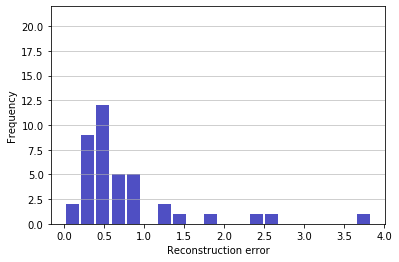

In [31]:
import matplotlib.pyplot as plt

# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=l2_diff_, bins=20, color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Reconstruction error')
plt.ylabel('Frequency')
# plt.title('My Very Own Histogram')
# plt.text(23, 45, r'$mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=22)
# plt.savefig('./plots/error_histo_proposed.png',dpi=300, bbox_inches = "tight")
plt.savefig('./plots/error_histo_proposed.eps', format='eps',dpi=300, bbox_inches = "tight")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

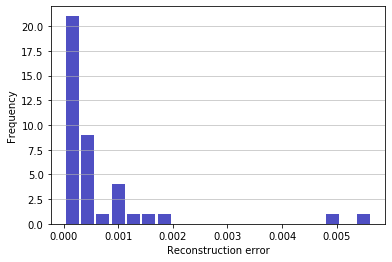

In [30]:
import matplotlib.pyplot as plt

# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=l2_diff*0.1, bins=20, color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Reconstruction error')
plt.ylabel('Frequency')
# plt.title('My Very Own Histogram')
# plt.text(23, 45, r'$mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=22)
# plt.savefig('./plots/error_histo_random.png',dpi=300, bbox_inches = "tight")
plt.savefig('./plots/error_histo_random.eps', format='eps',dpi=300, bbox_inches = "tight")

In [123]:
8.55/1.46

5.856164383561644